# Active Learning on Logistic Regression
## Configuration

In [1]:
# Config
"""
Set to a number to generate same split
Number of Iteration: number of iteraton of active learning
Number of Query: number of queries for to extract samples near to decision boundary
"""

random_state=0
number_of_iteration=7
number_of_query = 20

N_THRESHOLD = 1

## Active Learning Helper
### least_confident

1. Get probability of test data by calling `predict_proba`, return 2d vectors [0_probability, 1_probability]
2. For each vector, get max value of 2 probability values and negate the number to generate score. Higher score means higher uncertainty 
3. Get top N data.


In [2]:
# Active Learning Helper
# From https://github.com/davefernig/alp/
from __future__ import unicode_literals, division

from scipy.sparse import csc_matrix, vstack
from scipy.stats import entropy
from collections import Counter
import numpy as np

class ActiveLearner(object):
    _uncertainty_sampling_frameworks = [
        'entropy',
        'max_margin',
        'least_confident',
    ]

    _query_by_committee_frameworks = [
        'vote_entropy',
        'average_kl_divergence',
    ]

    def __init__(self, strategy='least_confident'):
        self.strategy = strategy

    def rank(self, clf, X_unlabeled, num_queries=None):
        if num_queries == None:
            num_queries = X_unlabeled.shape[0]

        elif type(num_queries) == float:
            num_queries = int(num_queries * X_unlabeled.shape[0])

        if self.strategy in self._uncertainty_sampling_frameworks:
            scores = self.__uncertainty_sampling(clf, X_unlabeled)

        elif self.strategy in self._query_by_committee_frameworks:
            scores = self.__query_by_committee(clf, X_unlabeled)

        else: 
            raise ValueError(
                "No input strategy"
            )
        rankings = np.argsort(-scores)[:num_queries]
        return rankings

    def __uncertainty_sampling(self, clf, X_unlabeled):
        probs = clf.predict_proba(X_unlabeled)

        if self.strategy == 'least_confident':
            return 1 - np.amax(probs, axis=1)

        elif self.strategy == 'max_margin':
            margin = np.partition(-probs, 1, axis=1)
            return -np.abs(margin[:,0] - margin[:, 1])

        elif self.strategy == 'entropy':
            return np.apply_along_axis(entropy, 1, probs)

    def __query_by_committee(self, clf, X_unlabeled):
        num_classes = len(clf[0].classes_)
        C = len(clf)
        preds = []

        if self.strategy == 'vote_entropy':
            for model in clf:
                y_out = map(int, model.predict(X_unlabeled))
                preds.append(np.eye(num_classes)[y_out])

            votes = np.apply_along_axis(np.sum, 0, np.stack(preds)) / C
            return np.apply_along_axis(entropy, 1, votes)

        elif self.strategy == 'average_kl_divergence':
            for model in clf:
                preds.append(model.predict_proba(X_unlabeled))

            consensus = np.mean(np.stack(preds), axis=0)
            divergence = []
            for y_out in preds:
                divergence.append(entropy(consensus.T, y_out.T))
            
            return np.apply_along_axis(np.mean, 0, np.stack(divergence))

class RandomLearner(object):
    """
    Random return idx
    for control group
    """

    def __init__(self, strategy=''):
        self.strategy = strategy

    def rank(self, clf, X_unlabeled, num_queries=None):
        if num_queries == None:
            num_queries = X_unlabeled.shape[0]

        elif type(num_queries) == float:
            num_queries = int(num_queries * X_unlabeled.shape[0])

        idx = np.arange(len(X_unlabeled))
        np.random.shuffle(idx)
        return idx[:num_queries]

In [3]:
def process(X, y, learner, model, config):
    # Initialization
    precisions = []
    recalls = []
    predict_proba = []
    
    parameter = [
        "test_size", # test/(train + test)
        "random_state",
        "init_size", # 
        "query_each_iteration",
    ]
    
    default_config = {
        "test_size": 0.4,
        "random_state": 0,
        "init_size": 0.5,
        "query_each_iteration": 5,
    }
    
    cfg = {}

    # load config
    for k in parameter:
        cfg[k] = config[k] if config.get(k) else default_config[k]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=cfg["test_size"], random_state=cfg["random_state"])

    init_size = int(np.ceil(X_train.shape[0] * cfg["init_size"]))
    pool_size = X_train.shape[0] - init_size
    X_init = X_train[:init_size] 
    y_init = y_train[:init_size]
    X_pool = X_train[init_size:]
    y_pool = y_train[init_size:]
    X_train = X_init
    y_train = y_init
    number_of_iteration = int(np.ceil(pool_size/cfg["query_each_iteration"]))
    query_each_iteration = cfg["query_each_iteration"]
    
    print("Initial training set size:", init_size, "(", cfg["init_size"], ")")
    print("Query each iteration:", cfg["query_each_iteration"])

    # init state
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, y_predict)
    precisions.append(precision[N_THRESHOLD])
    recalls.append(recall[N_THRESHOLD])
    print("init")
    print("@P:", precision)
    print("@R:", recall)
    print(thresholds)
    print()
    

    # Active Learning
    for i in range(number_of_iteration):
        idx = learner.rank(model, X_pool, query_each_iteration)
        t = model.predict_proba(X_pool[idx[0]:])
        min_certain = np.amax(model.predict_proba(X_pool[idx[0:1]]))
        max_certain = np.amax(model.predict_proba(X_pool[idx[-1:]]))
        predict_proba.append([min_certain, max_certain])
        X_train = np.concatenate([X_train, X_pool[idx, :]])
        y_train = np.concatenate([y_train, y_pool[idx]])
        X_pool = np.delete(X_pool, idx, axis=0)
        y_pool = np.delete(y_pool, idx, axis=0)
        model.fit(X_train, y_train)
        # metrics
        y_predict = model.predict(X_test)
        precision, recall, thresholds = precision_recall_curve(y_test, y_predict)
        precisions.append(precision[N_THRESHOLD])
        recalls.append(recall[N_THRESHOLD])
        print("Round: ", i+1)
        print("Proba:", min_certain, max_certain)
        print("Train: ", len(X_train))
        print("Test: ", len(X_test))
        print("@P:", precision)
        print("@R:", recall)
        print(thresholds)
    
    debug = {
        "X_train": X_train
    }
    
    info = {
        "predict_proba": [predict_proba[0]] + predict_proba
    }
    
    return precisions, recalls, debug, info

In [4]:
import numpy as np
import sklearn
from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# metrics
from sklearn.metrics import precision_recall_curve
# plot
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
config = {
    "test_size":0.4, 
    "random_state": random_state,
    "init_size": 0.3,
    "query_each_iteration": 5
}

In [6]:
# Active Learning

#Load Data
path = "data/"
y = np.array([])
T1 = np.loadtxt(path+"hurricane.vec")
T = T1
y = np.append(y, np.ones(len(T)))
F1 = np.loadtxt(path+"lasvegas.vec")
F2 = np.loadtxt(path+"false.vec")
F = np.append(F1, F2, axis=0)
y = np.append(y, np.zeros(len(F)))
embedding = np.append(T,F,axis=0)
X = sklearn.preprocessing.normalize(embedding)

model = sklearn.linear_model.LogisticRegressionCV()
active_learner = ActiveLearner("least_confident")

active_learning_precision, active_learning_recall, debug1, info1 = process(X, y, active_learner, model, config)

Initial training set size: 102 ( 0.3 )
Query each iteration: 5
init
@P: [ 0.34801762  0.77941176  1.        ]
@R: [ 1.          0.67088608  0.        ]
[ 0.  1.]

Round:  1
Proba: 0.524174094404 0.554203980677
Train:  107
Test:  227
@P: [ 0.34801762  0.82089552  1.        ]
@R: [ 1.          0.69620253  0.        ]
[ 0.  1.]
Round:  2
Proba: 0.503867103055 0.530038556387
Train:  112
Test:  227
@P: [ 0.34801762  0.80882353  1.        ]
@R: [ 1.          0.69620253  0.        ]
[ 0.  1.]
Round:  3
Proba: 0.513052517667 0.557879575369
Train:  117
Test:  227
@P: [ 0.34801762  0.84375     1.        ]
@R: [ 1.         0.6835443  0.       ]
[ 0.  1.]
Round:  4
Proba: 0.502498541846 0.525823551139
Train:  122
Test:  227
@P: [ 0.34801762  0.86885246  1.        ]
@R: [ 1.          0.67088608  0.        ]
[ 0.  1.]
Round:  5
Proba: 0.547683846135 0.57559999079
Train:  127
Test:  227
@P: [ 0.34801762  0.9         1.        ]
@R: [ 1.         0.6835443  0.       ]
[ 0.  1.]
Round:  6
Proba: 0.50572

In [7]:
# Control Group

#Load Data
path = "data/"
y = np.array([])
T1 = np.loadtxt(path+"hurricane.vec")
T = T1
y = np.append(y, np.ones(len(T)))
F1 = np.loadtxt(path+"lasvegas.vec")
F2 = np.loadtxt(path+"false.vec")
F = np.append(F1, F2, axis=0)
y = np.append(y, np.zeros(len(F)))
embedding = np.append(T,F,axis=0)
X = sklearn.preprocessing.normalize(embedding)

model = sklearn.linear_model.LogisticRegressionCV()
random_learner = RandomLearner()

control_group_precision, control_group_recall, debug2, info2 = process(X, y, random_learner, model, config)

Initial training set size: 102 ( 0.3 )
Query each iteration: 5
init
@P: [ 0.34801762  0.77941176  1.        ]
@R: [ 1.          0.67088608  0.        ]
[ 0.  1.]

Round:  1
Proba: 0.961406701689 0.999058831472
Train:  107
Test:  227
@P: [ 0.34801762  0.82089552  1.        ]
@R: [ 1.          0.69620253  0.        ]
[ 0.  1.]
Round:  2
Proba: 0.909182164552 0.941741534992
Train:  112
Test:  227
@P: [ 0.34801762  0.80882353  1.        ]
@R: [ 1.          0.69620253  0.        ]
[ 0.  1.]
Round:  3
Proba: 0.997804415561 0.94146552959
Train:  117
Test:  227
@P: [ 0.34801762  0.828125    1.        ]
@R: [ 1.          0.67088608  0.        ]
[ 0.  1.]
Round:  4
Proba: 0.990802201386 0.714756248637
Train:  122
Test:  227
@P: [ 0.34801762  0.87272727  1.        ]
@R: [ 1.          0.60759494  0.        ]
[ 0.  1.]
Round:  5
Proba: 0.773933996972 0.972455961053
Train:  127
Test:  227
@P: [ 0.34801762  0.88888889  1.        ]
@R: [ 1.          0.60759494  0.        ]
[ 0.  1.]
Round:  6
Proba: 0

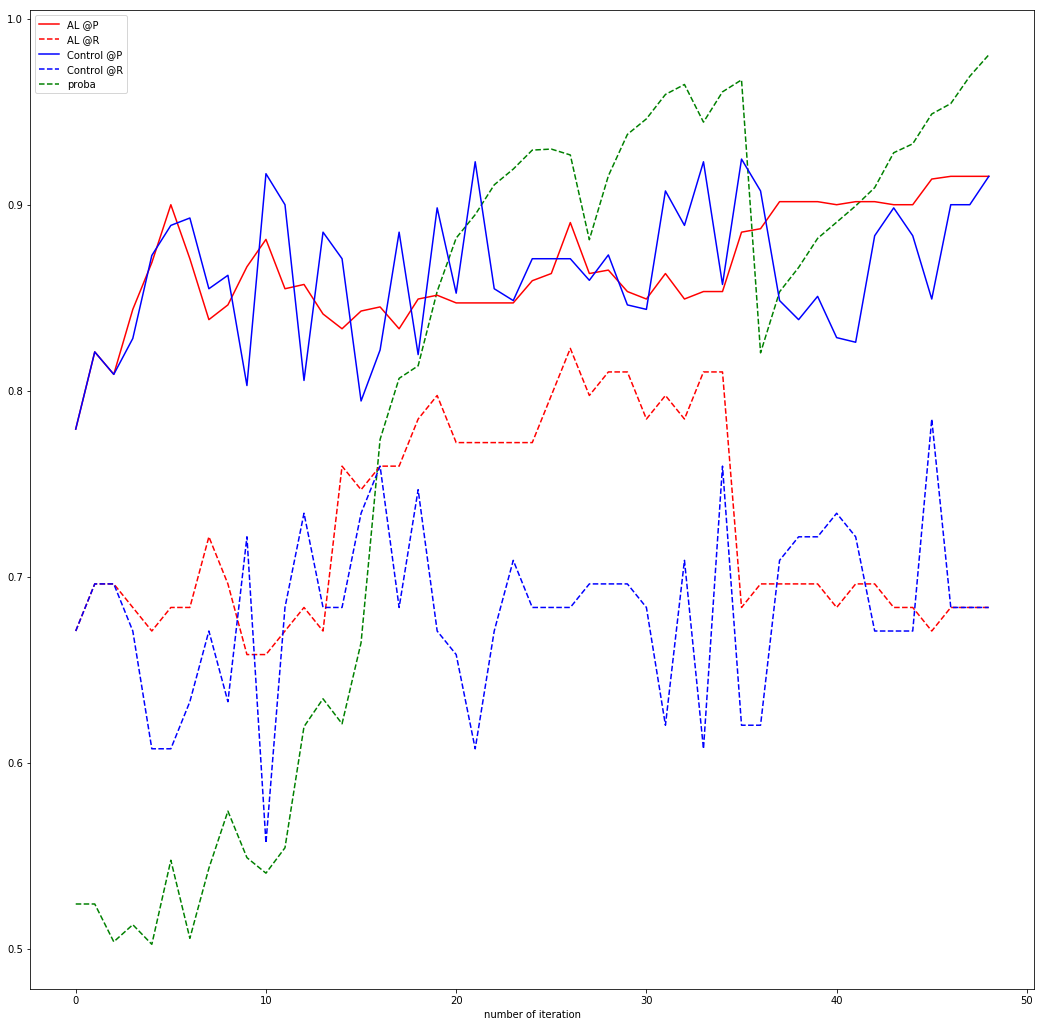

In [10]:
x = range(len(active_learning_precision))
plt.figure(figsize=(18, 18))
plt.xlabel("number of iteration")
proba, = plt.plot(x, [n[0] for n in info1["predict_proba"]],"g--" , label="proba")
p1, = plt.plot(x, active_learning_precision, "r-", label="AL @P")
r1, = plt.plot(x, active_learning_recall, "r--", label="AL @R")
p2, = plt.plot(x, control_group_precision, "b-", label="Control @P")
r2, = plt.plot(x, control_group_recall, "b--", label="Control @R")
plt.legend(handles=[p1, r1, p2, r2, proba])

In [9]:
# Debug Utils
def compare_X_train():
    xt1 = debug1["X_train"]
    xt2 = debug2["X_train"]
    a = set([tuple(l) for l in xt1])
    b = set([tuple(l) for l in xt2])
    if a - b:
        print("invalid X train: should be same X train")
compare_X_train()